# Curso de Manejo de Datos Faltantes: Imputación

## Configuración de ambiente de trabajo

## Importar librerías

In [1]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [2]:
%run notebooks/pandas-missing-extension.ipynb

c:\Programacion\Python\Python310\lib\site-packages\upsetplot\plotting.py:20: MatplotlibDeprecationWarning: The matplotlib.tight_layout module was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  from matplotlib.tight_layout import get_renderer


## Configurar el aspecto general de las gráficas del proyecto

In [3]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

In [4]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df: pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df

,ozone,solar_r,wind,temp,month,day,year
date,,,,,,,
1973-05-01,41.0,190.0,7.4,67,5,1,1973
1973-05-02,36.0,118.0,8.0,72,5,2,1973
1973-05-03,12.0,149.0,12.6,74,5,3,1973
1973-05-04,18.0,313.0,11.5,62,5,4,1973
1973-05-05,NaN,NaN,14.3,56,5,5,1973
...,...,...,...,...,...,...,...
1973-09-26,30.0,193.0,6.9,70,9,26,1973
1973-09-27,NaN,145.0,13.2,77,9,27,1973
1973-09-28,14.0,191.0,14.3,75,9,28,1973


In [5]:
(
    smf.ols(
        formula="temp ~ ozone",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.488
Model:,OLS,Adj. R-squared:,0.483
Method:,Least Squares,F-statistic:,108.5
Date:,"Sat, 28 Jan 2023",Prob (F-statistic):,2.93e-18
Time:,15:58:18,Log-Likelihood:,-386.27
No. Observations:,116,AIC:,776.5
Df Residuals:,114,BIC:,782.1
Df Model:,1,,
Covariance Type:,nonrobust,,


In [6]:
(
    smf.ols(
        formula="temp ~ ozone + solar_r",
        data=airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

Dep. Variable:,temp,R-squared:,0.491
Model:,OLS,Adj. R-squared:,0.481
Method:,Least Squares,F-statistic:,52.07
Date:,"Sat, 28 Jan 2023",Prob (F-statistic):,1.47e-16
Time:,15:58:18,Log-Likelihood:,-369.78
No. Observations:,111,AIC:,745.6
Df Residuals:,108,BIC:,753.7
Df Model:,2,,
Covariance Type:,nonrobust,,


### Reto: Datos de supervivientes

In [7]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [8]:
(
    smf.ols(
        formula="age ~ death",
        data=survival_df
    )
    .fit()
    .summary()
)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.287
Model:                            OLS   Adj. R-squared:                  0.287
Method:                 Least Squares   F-statistic:                     3172.
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:58:20   Log-Likelihood:                -28326.
No. Observations:                7874   AIC:                         5.666e+04
Df Residuals:                    7872   BIC:                         5.667e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     60.8359      0.117    520.159      0.000      60.607      61.065
death         12.5504      0.223     56.321      0.000      12.114      12.987
==============================================================================
Omnibus:                      129.087   Durbin-Watson:                   0.577
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              130.198
Skew:                           0.297   Prob(JB):                     5.34e-29
Kurtosis:                       2.789   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Preparando datos: _National Health and Nutrition Examination Survey_

c:\Programacion\Python\Python310\lib\site-packages\missingno\missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
c:\Programacion\Python\Python310\lib\site-packages\missingno\missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


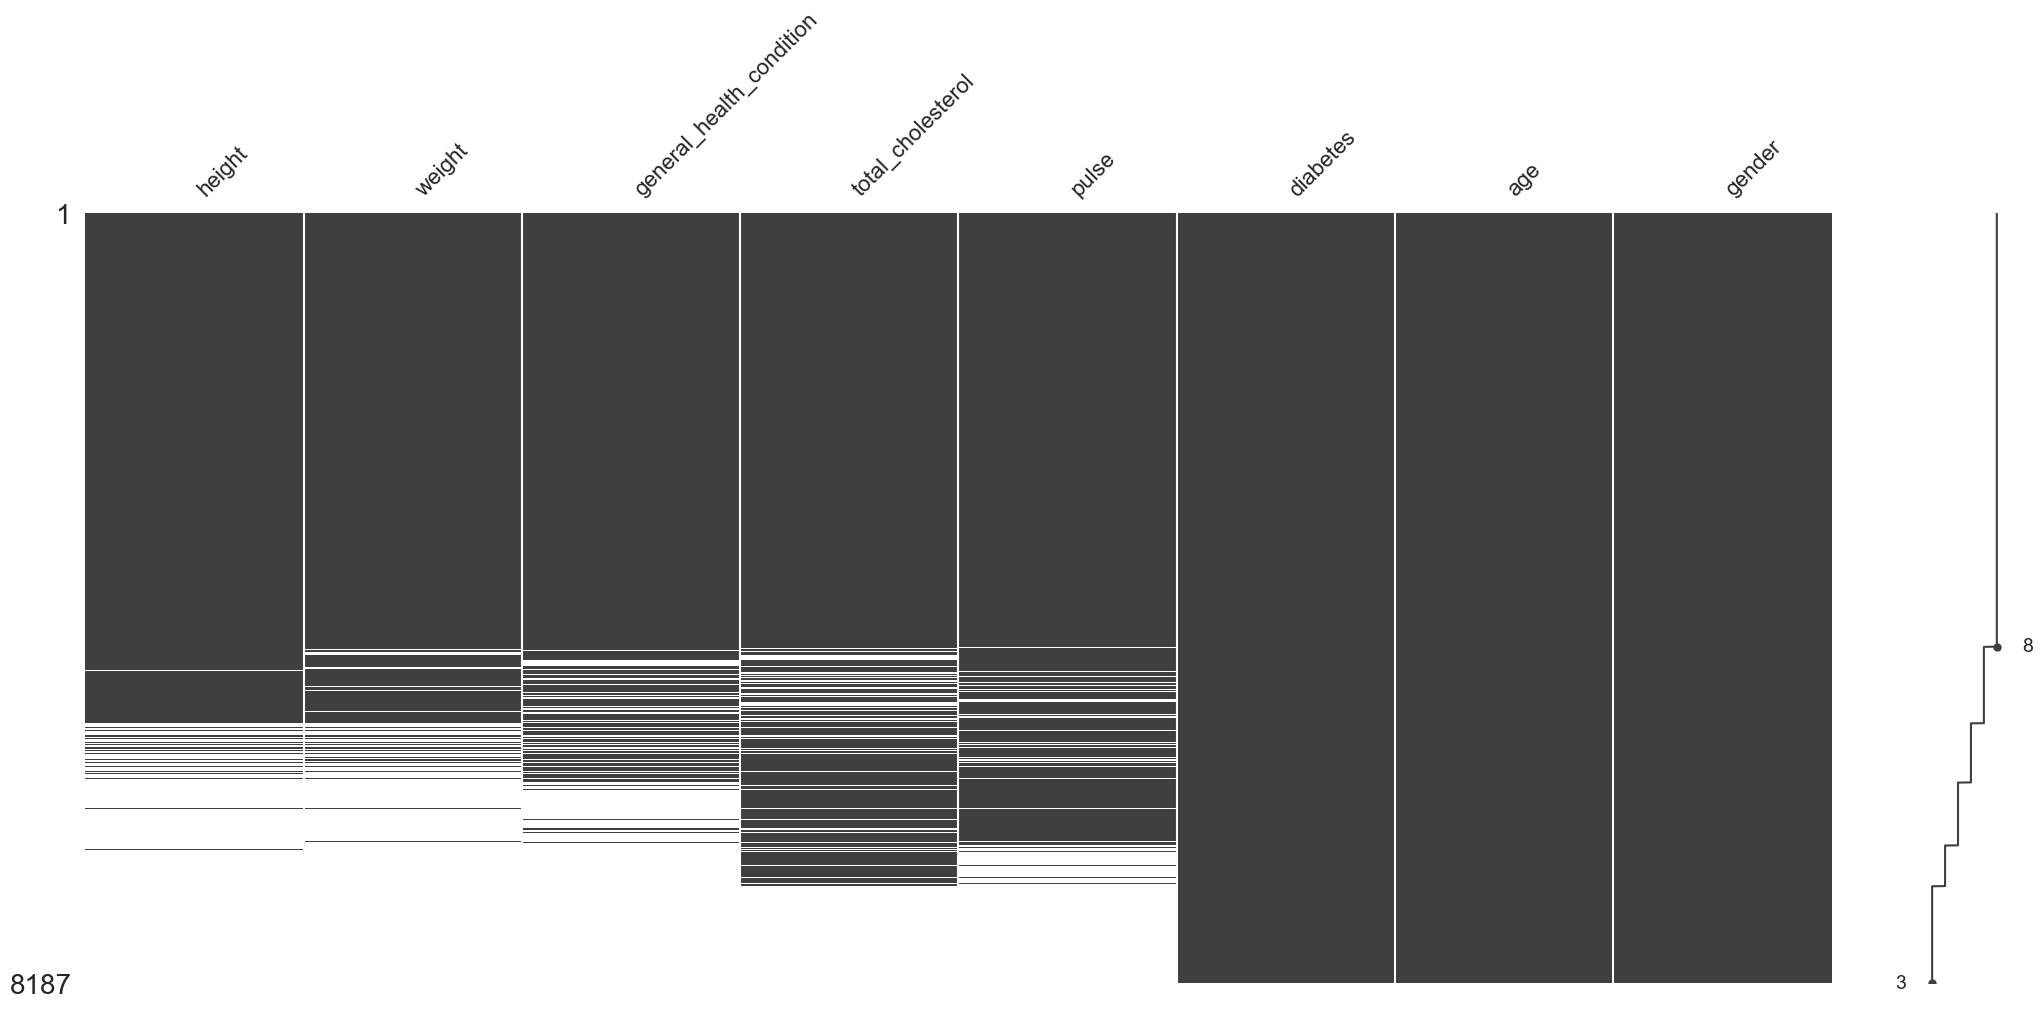

c:\Programacion\Python\Python310\lib\site-packages\upsetplot\plotting.py:580: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)
c:\Programacion\Python\Python310\lib\site-packages\upsetplot\plotting.py:586: MatplotlibDeprecationWarning: The get_renderer function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use figure.canvas.get_renderer() instead.
  window_extent_args["renderer"] = get_renderer(fig)


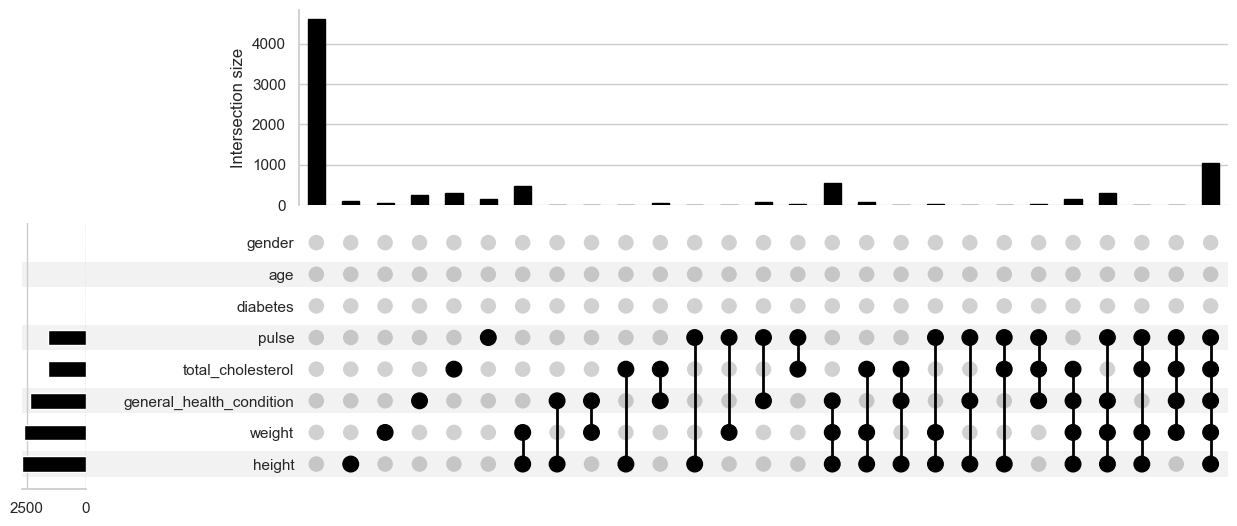

c:\Programacion\Python\Python310\lib\site-packages\missingno\missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
c:\Programacion\Python\Python310\lib\site-packages\missingno\missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


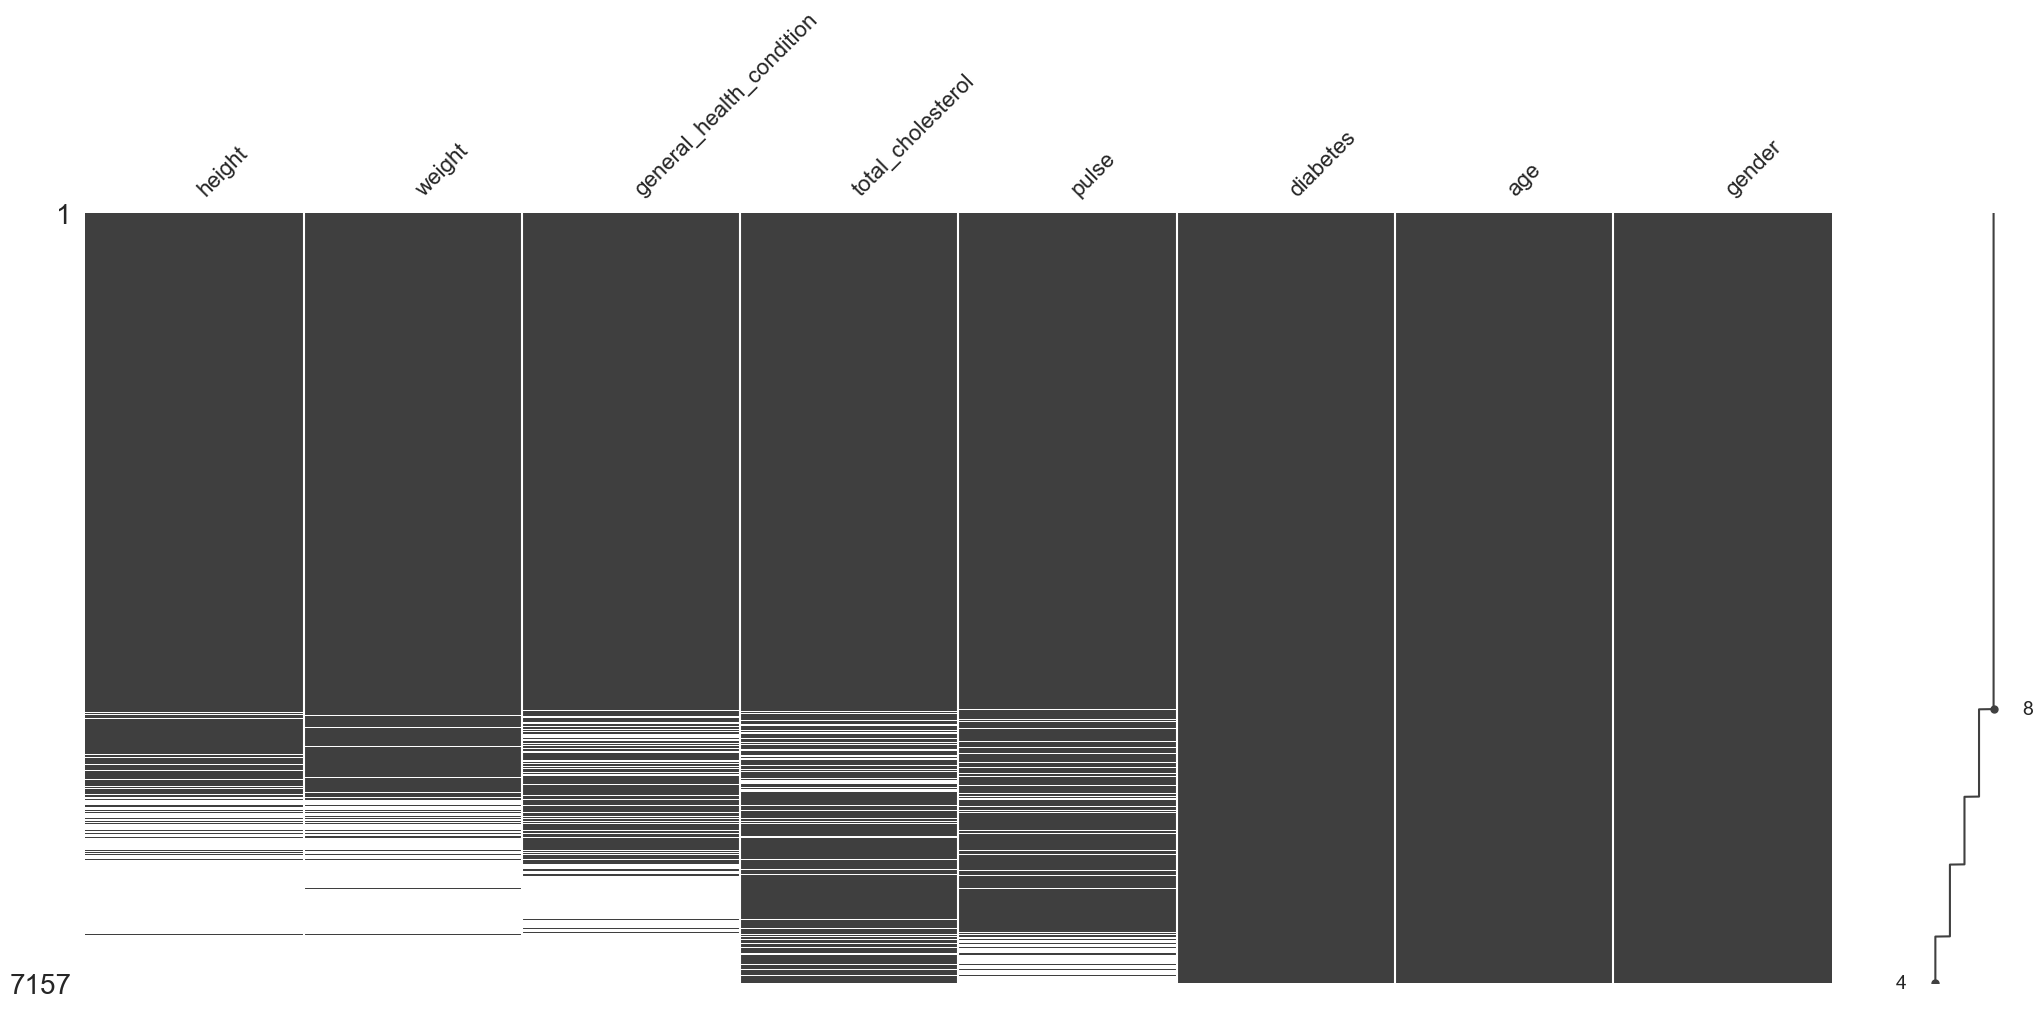

In [9]:
%run download-data-and-load-it.ipynb

## Consideración y evaluación de los distintos tipos de valores faltantes

![](images/missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [13]:
female_weight, male_weight =(
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative="two-sided"
)

Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

## Amplía tu conjunto de herramientas para explorar valores faltantes

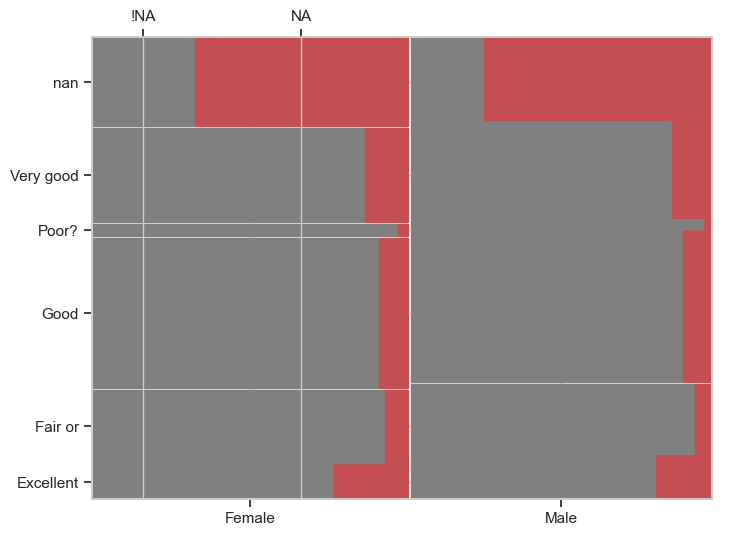

In [17]:
(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df: df.weight.isna().replace([True, False], ["NA", "!NA"])
    )
    .groupby(
        ["gender", "general_health_condition", "weight"],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties = lambda key: {"color": "r" if "NA" in key else "gray"},
            horizontal = True,
            axes_label = True,
            title = "",
            labelizer = lambda key: ""
        )
    )
);

## Tratamiento de variables categóricas para imputación de valores faltantes

In [35]:
# creamos una copia de nuestro DataFRame
nhanes_transformed_df = nhanes_df.copy(deep = True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por característica y los transformaremos utilizando una codificación ordinal.

In [37]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [38]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [39]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [41]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [44]:
#Obtenemos el nombre de nuestras variables categóricas
categorical_columns = nhanes_df.select_dtypes(include=[object, "category"]).columns

In [47]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

In [53]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns=categorical_transformer.get_feature_names_out(),
        index=nhanes_df.index,
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)
nhanes_transformed_df

,general_health_condition,gender,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,
93705.0,2.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,4.0,1.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,2.0,1.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,NaN,0.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,4.0,1.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...
102949.0,0.0,1.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,1.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,2.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [ ]:
# gender_encoder = sklearn.preprocessing.OrdinalEncoder()

# gender_values = (
#     nhanes_df
#     .gender
#     .values
#     .reshape(-1, 1)
# )

# (
#     gender_encoder
#     .fit_transform(
#         X = gender_values
#     )
#     .squeeze()
# )

# (
#     nhanes_df.gender.unique(),
#     nhanes_transformed_df.gender.unique(),
#     gender_encoder.categories_
# )

### _One Hot Encoding_

In [55]:
nhanes_transformed_df2 = nhanes_df.copy(deep = True)

### `pandas.get_dummies()` vs `sklearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [57]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .pipe(pd.get_dummies)
)

,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,0,0,1,0,0
93706.0,0,0,0,0,1
93707.0,0,0,1,0,0
93709.0,0,0,0,0,0
93711.0,0,0,0,0,1
...,...,...,...,...,...
102949.0,1,0,0,0,0
102953.0,0,1,0,0,0
102954.0,0,0,1,0,0


#### `sklearn.preprocessing.OneHotEncoder()`

In [58]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder = "passthrough"
)

In [60]:
# recreamos nuestro conjunto de datos utilizando nuestro transformador
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns=transformer.get_feature_names_out(),
        index=nhanes_df.index,
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
)
nhanes_transformed_df2

,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,height,weight,total_cholesterol,pulse,diabetes,age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [61]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [63]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]] # Buscamos la tercer categoría
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

## Imputación por interpolación

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Información de sesión

In [10]:
session_info.show()

c:\Programacion\Python\Python310\lib\site-packages\session_info\main.py:213: DeprecationWarning: Accessing jsonschema.__version__ is deprecated and will be removed in a future release. Use importlib.metadata directly to query for jsonschema's version.
  mod_version = _find_version(mod.__version__)
